<a href="https://colab.research.google.com/github/nandorrefi/PokerBot/blob/main/ThePokerBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing packages for Colab
Run this section in Google Colab environment. This will also restart the currently running runtime.

In [ ]:
!pip install rlcard

In [ ]:
pip install dm-env

In [ ]:
pip install dm-acme

In [ ]:
pip install dm-acme[reverb]

In [ ]:
pip install dm-acme[tf]

In [ ]:
!pip install tensorflow-gpu tensorflow-probability

In [ ]:
!pip install dm-sonnet

In [ ]:
# after installing we restart the colab runtime
import os
os.kill(os.getpid(), 9)

# Wrappers
To use the Acme and RLCard libraries simultaneously I've created adapters to match their interfaces and also adding more functionality to certain components

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
import sonnet as snt

print("TensorFlow version {}".format(tf.__version__))
print("Sonnet version {}".format(snt.__version__))

TensorFlow version 2.4.1
Sonnet version 2.0.0


In [3]:
import rlcard
import dm_env
from dm_env import specs
import numpy as np
from rlcard.agents import RandomAgent
from rlcard.utils import tournament

WAINING - RLCard supports Tensorflow >=1.14 and <2.0
The detected version is 2.4.1 
If the models can not be loaded, please install Tensorflow via
$ pip install rlcard[tensorflow]



In [4]:
class DmEnvWrapper(dm_env.Environment):
    def __init__(self, env):
        self.env = env
        state = self.env.reset()['obs'].astype('float32')
        self.state_shape = state.shape
        self.state_dtype = state.dtype
        self.rewards = []
        self.eval_rewards = []
        self.curr_episode = 0
        self.eval_after = 1000
        self.opponent = None
        self.agent = None
    
    def reset(self):
        state = self.env.reset()
        return dm_env.restart(state['obs'].astype('float32'))

    def step(self, action):
        state_next, reward, done = self.env.step(action)

        if done:
            print(f"Episode: {self.curr_episode}\t Reward: {reward}")
            self.rewards.append(reward)

            self.curr_episode += 1

            if self.curr_episode % self.eval_after == 0:
                env_eval = rlcard.make('limit-holdem', config={'seed': 0})
                env_eval.set_agents([self.agent, self.opponent])
                self.eval_rewards.append(tournament(env_eval, 1000)[0])

            return dm_env.termination(reward=reward, observation=state_next['obs'].astype('float32'))
        else:
            return dm_env.transition(reward=reward, observation=state_next['obs'].astype('float32'), discount=0.9)

    def observation_spec(self):
        return specs.BoundedArray(shape=self.state_shape, dtype=self.state_dtype, name="table", minimum=0, maximum=1)

    def action_spec(self):
        return specs.DiscreteArray(dtype=np.int32, num_values=self.env.action_num, name="action")

    def set_agents(self, agent, opponent):
        self.agent = agent
        self.opponent = opponent

In [5]:
from acme.agents.tf.dqn import DQN
from acme import make_environment_spec
from acme.tf import networks
import acme
from acme.utils import loggers

import numpy as np
from sonnet.nets import MLP

In [6]:
class DQN_wrapper(DQN):
    def __init__(self, *args, **kwargs):
        super(DQN_wrapper, self).__init__(*args, **kwargs)
        self.use_raw = False

    def step(self, state):
        observation = state['obs'].astype('float32')
        if isinstance(state, dict):
            timestep = dm_env.restart(observation=observation)
        else:
            reward = state[1]
            timestep = dm_env.transition(reward=reward, observation=observation, discount=0.9)

        action = self.select_action(timestep.observation)
        return action

    def eval_step(self, state):
        return (self.step(state), 0)

    

# Initializing
Run this section to initialize training environment and to initialize and load the agent for training, testing or playing.

In [7]:
import warnings

In [8]:
from tensorflow.train import Checkpoint
from tensorflow.train import latest_checkpoint
import os

In [9]:
def load_existing_network(checkpoint, dir):
    if os.path.isdir(dir):
        load_latest_network(network_checkpoint, dir)
    else:
        warnings.warn(f"\nWARNING: Couldn't load checkpoint. Folder does not exists: {dir}")

In [10]:
def load_latest_network(checkpoint, dir):
    save_path = latest_checkpoint(dir)
    checkpoint.restore(save_path)

In [35]:
import shutil
import os

def download_checkpoints():
    !git clone https://github.com/nandorrefi/PokerBot
    
    cwd = os.getcwd()
    
    zip_file = 'ckpt.zip'
    git_folder_name = 'PokerBot'
    zip_path = os.path.join(cwd, 
                            os.path.join(git_folder_name, zip_file))
    
    if os.path.exists(zip_path):
        shutil.move(zip_path, cwd)
        new_zip_path = os.path.join(cwd, zip_file)
        !unzip new_zip_path
        !rm -rf PokerBot
        !rm $new_zip_path

In [11]:
env = DmEnvWrapper(rlcard.make('limit-holdem', config={'seed': 0, 'single_agent_mode':True}))
env_spec = make_environment_spec(env)

# Dense neural network to predict Q values for DQN agent
# Input shape is (72,)
# There are 4 actions for output:
#   call, raise, fold, check
network = MLP([72, 256, 256, 128, 4])
network_checkpoint = Checkpoint(network)

ckpt_folder = 'ckpt/network/'
ckpt_name = 'network'

WAINING - RLCard supports Tensorflow >=1.14 and <2.0
The detected version is 2.4.1 
If the models can not be loaded, please install Tensorflow via
$ pip install rlcard[tensorflow]



In [12]:
# Downloading saved agent from github
download_checkpoints()

# If exist load previous network
load_existing_network(network_checkpoint, ckpt_folder)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: 
  """


In [13]:
agent = DQN_wrapper(env_spec, 
                    network,
                    logger=loggers.NoOpLogger(), 
                    checkpoint=True, 
                    checkpoint_subpath='ckpt/')
opponent = RandomAgent(action_num=env.env.action_num)
env.set_agents(agent, opponent)

# Training

In [ ]:
loop = acme.EnvironmentLoop(env, agent, logger=loggers.NoOpLogger())
loop.run(num_episodes=300000)

In [15]:
network_checkpoint.save(ckpt_folder + ckpt_name)

'ckpt/network/network-1'

# Zip agent checkpoints in Colab

In [16]:
!zip -r ckpt.zip ckpt

  adding: ckpt/ (stored 0%)
  adding: ckpt/f0de4292-6121-11eb-8285-0242ac1c0002/ (stored 0%)
  adding: ckpt/f0de4292-6121-11eb-8285-0242ac1c0002/checkpoints/ (stored 0%)
  adding: ckpt/f0de4292-6121-11eb-8285-0242ac1c0002/checkpoints/dqn_learner/ (stored 0%)
  adding: ckpt/f0de4292-6121-11eb-8285-0242ac1c0002/checkpoints/dqn_learner/ckpt-1.data-00000-of-00001 (deflated 8%)
  adding: ckpt/f0de4292-6121-11eb-8285-0242ac1c0002/checkpoints/dqn_learner/ckpt-1.index (deflated 63%)
  adding: ckpt/f0de4292-6121-11eb-8285-0242ac1c0002/checkpoints/dqn_learner/checkpoint (deflated 42%)
  adding: ckpt/network/ (stored 0%)
  adding: ckpt/network/network-1.index (deflated 52%)
  adding: ckpt/network/network-1.data-00000-of-00001 (deflated 7%)
  adding: ckpt/network/checkpoint (deflated 37%)


# Results

In [17]:
import matplotlib.pyplot as plt
import matplotlib

In [18]:
matplotlib.use('module://ipykernel.pylab.backend_inline', warn=False, force=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  """Entry point for launching an IPython kernel.


Rewards statistics:
Min reward: -25.0	Max reward: 25.0	Mean reward: 0.21454333333333334

Mean rewards statistics:
Min mean reward: -0.5285	Max mean reward: 0.5515	Overall mean reward: 0.2142090301003344
Min eval reward: 0.8355	Max eval reward: 1.85	Overall eval reward: 1.3781016666666666


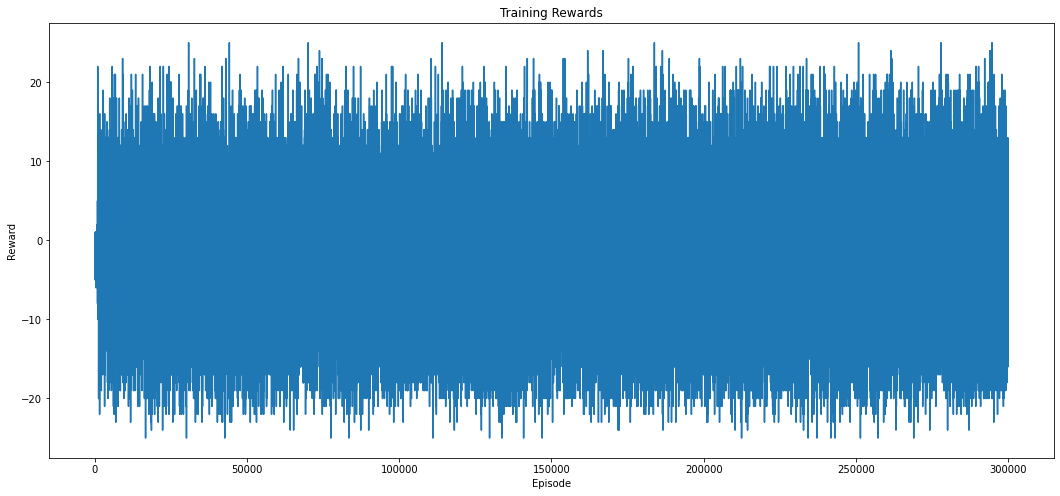

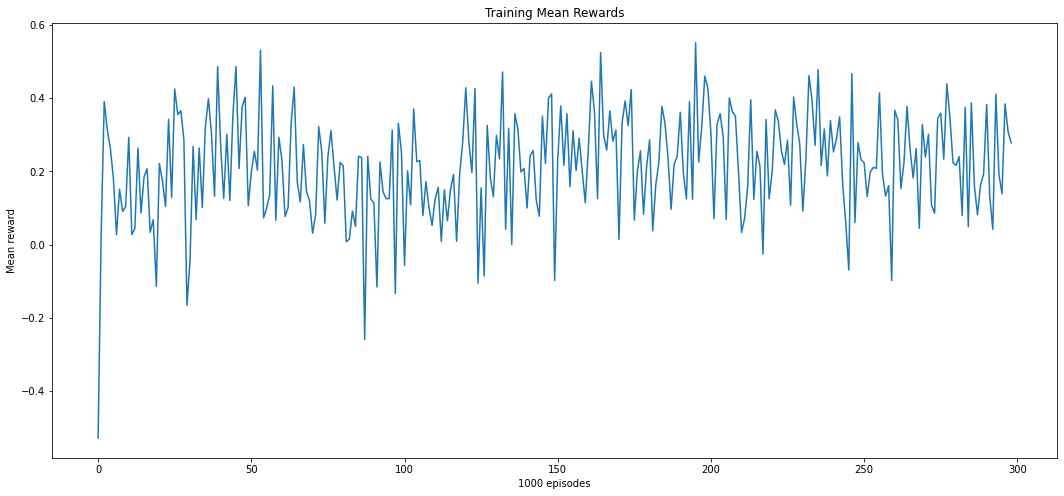

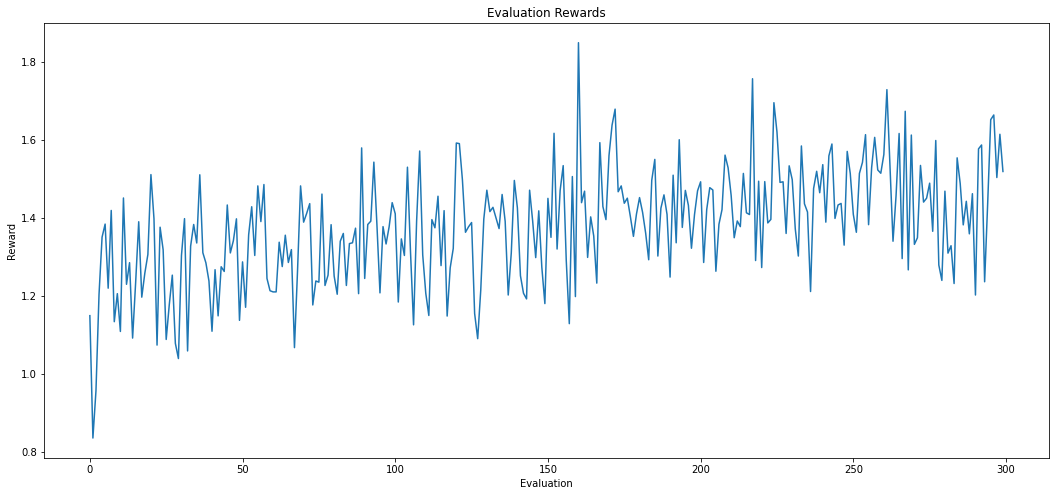

In [19]:
rewards = env.rewards

print('Rewards statistics:')
print('Min reward: ' + str(np.min(rewards)) + '\tMax reward: ' 
      + str(np.max(rewards)) + '\tMean reward: ' + str(np.mean(rewards)))

plt.figure(figsize=(18,8))
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(rewards)

interval = 1000
mean_rewards = []

for i in range(interval, int(len(rewards)), interval):
    mean_rewards.append(np.mean(rewards[i-interval:i]))

print('\nMean rewards statistics:')
print('Min mean reward: ' + str(np.min(mean_rewards)) + '\tMax mean reward: ' 
      + str(np.max(mean_rewards)) + '\tOverall mean reward: ' + str(np.mean(mean_rewards)))

plt.figure(figsize=(18,8))
plt.title('Training Mean Rewards')
plt.xlabel(str(interval) + ' episodes')
plt.ylabel('Mean reward')
plt.plot(mean_rewards)

eval_rewards = env.eval_rewards

print('Min eval reward: ' + str(np.min(eval_rewards)) + '\tMax eval reward: ' 
      + str(np.max(eval_rewards)) + '\tOverall eval reward: ' + str(np.mean(eval_rewards)))

plt.figure(figsize=(18,8))
plt.title('Evaluation Rewards')
plt.xlabel('Evaluation')
plt.ylabel('Reward')
plt.plot(eval_rewards)

# Test

In [22]:
env_test = rlcard.make('limit-holdem', config={'seed': 0})

opponent_test = RandomAgent(action_num=env_test.action_num)
env_test.set_agents([agent, opponent_test])

rounds = 1000
mean_test_reward = tournament(env_test, rounds)[0]

print(f"Played {rounds} rounds against random agent and \
won on average {mean_test_reward} times of the amount of the big blind.")

Played 1000 rounds against random agent and won on average 1.5605 times of the amount of the big blind.


# Playing against the agent

In [14]:
from rlcard.agents import LimitholdemHumanAgent as HumanAgent
from rlcard.utils.utils import print_card

In [17]:
# Make environment and enable human mode
# Set 'record_action' to True because we need it to print results
human_env = rlcard.make('limit-holdem', config={'record_action': True})
human_agent = HumanAgent(human_env.action_num)

human_env.set_agents([human_agent, agent])

In [18]:
print(">> Limit Hold'em random agent")

while (True):
    print(">> Start a new game")

    trajectories, payoffs = human_env.run(is_training=False)
    # If the human does not take the final action, we need to
    # print other players action
    if len(trajectories[0]) != 0:
        final_state = trajectories[0][-1][-2]
        action_record = final_state['action_record']
        state = final_state['raw_obs']
        _action_list = []
        for i in range(1, len(action_record)+1):
            _action_list.insert(0, action_record[-i])
        for pair in _action_list:
            print('>> Player', pair[0], 'chooses', pair[1])

    # Let's take a look at what the agent card is
    print('===============       DQN      ===============')
    print_card(human_env.get_perfect_information()['hand_cards'][1])

    print('===============     Result     ===============')
    if payoffs[0] > 0:
        print('You win {} chips!'.format(payoffs[0]))
    elif payoffs[0] == 0:
        print('It is a tie.')
    else:
        print('You lose {} chips!'.format(-payoffs[0]))
    print('')

    input("Press any key to continue...")

>> Limit Hold'em random agent
>> Start a new game
>> Player 1 chooses call

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│4        │   │7        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♦    │
│         │   │         │
│         │   │         │
│        4│   │        7│
└─────────┘   └─────────┘
===============     Chips      ===============
Yours:   ++
++++
=========== Actions You Can Choose ===========
0: raise, 1: fold, 2: check

>> You choose action (integer): 0
>> Player 1 chooses call
>> Player 0 chooses raise
>> Player 1 chooses raise

=============== Community Card ===============









===============   Your Hand    ===============
┌─────────┐   ┌─────────┐
│4        │   │7        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♦    │
│         │   │         │
│         │   │         │
│        4│   │        7│
└─────────┘   └─────────

KeyboardInterrupt: ignored